In [2]:
%matplotlib inline
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pykitti import odometry
import os

In [3]:
basedir = '/home/paperspace/data_odometry_color/dataset/'
sequences = []
for i in range(22):
    sequences.append('%02d'%i)
train_sequences = sequences[0:9]
test_sequences = sequences[9:11]

In [4]:
import os
import itertools

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


In [5]:
def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

In [6]:
import pickle as p

with open('pose_scaler.p', 'rb') as fp:
    scaler = p.load(fp)

In [ ]:
csw = os.getcwd()
writer = tf.python_io.TFRecordWriter("/home/paperspace/DeepOdometry/train_rot.tfrecord")
for sequence in train_sequences:
    print ("Sequence: ", sequence)
    dataset = odometry(basedir, sequence)
    dataset.imformat = 'cv2'
    img_raw_prev = None
    img_prev = None
    for i in range(len(dataset.timestamps)):
        if i % 500 == 0:
            print (i)

        img = dataset.gray(i)
        img = cv2.resize(img, (416, 128))
        
        img = img.astype(np.float32)
        img_raw = cv2.imencode('.jpg', img)[1].tostring()
    
        try:
            pose = next(iter(itertools.islice(dataset.poses, i, None)))
            pose = pose[:3, :4].astype(np.float64)
            pose = scaler.transform(pose.flatten().reshape(1, -1))
            pose = pose.tostring()
        except:
            print ("No ground pose so skipping this sequence.")
            break
            
        if i == 0:
            img_raw_prev = img_raw
            img_prev = img
        else:
            example = tf.train.Example(features=tf.train.Features(feature={ # SequenceExample for seuqnce example
                "pose": _bytes_feature(pose),
                'img_raw': _bytes_feature(img_raw),
                'img_raw_prev': _bytes_feature(img_raw_prev),
            }))
            writer.write(example.SerializeToString())
            img_raw_prev = img_raw
            img_prev = img
writer.close()
    

In [ ]:
csw = os.getcwd()
writer = tf.python_io.TFRecordWriter("/home/paperspace/DeepOdometry/eval_rot.tfrecord")
for sequence in test_sequences:
    print ("Sequence: ", sequence)
    dataset = odometry(basedir, sequence)
    dataset.imformat = 'cv2'
    img_raw_prev = None
    img_prev = None
    for i in range(len(dataset.timestamps)):
        if i % 500 == 0:
            print (i)

        img = dataset.gray(i)
        img = cv2.resize(img, (416, 128))

        
        img = img.astype(np.float32)
        img_raw = cv2.imencode('.jpg', img)[1].tostring()
    
        try:
            pose = next(iter(itertools.islice(dataset.poses, i, None)))
            pose = pose[:3, :4].astype(np.float64)
            pose = scaler.transform(pose.flatten().reshape(1, -1))
            pose = pose.tostring()
        except:
            print ("No ground pose so skipping this sequence.")
            break
            
        if i == 0:
            img_raw_prev = img_raw
            img_prev = img
        else:
            example = tf.train.Example(features=tf.train.Features(feature={ # SequenceExample for seuqnce example
                "pose": _bytes_feature(pose),
                'img_raw': _bytes_feature(img_raw),
                'img_raw_prev': _bytes_feature(img_raw_prev),
            }))
            writer.write(example.SerializeToString())
            img_raw_prev = img_raw
            img_prev = img
writer.close()

In [30]:
def parser(record):
    keys_to_features = {
        "pose": tf.FixedLenFeature((), tf.string, default_value=""),
        "img_raw": tf.FixedLenFeature((), tf.string, default_value=""),
        "img_raw_prev": tf.FixedLenFeature((), tf.string, default_value=""),
    }
    parsed = tf.parse_single_example(record, keys_to_features)
    seed = 42
    # Perform additional preprocessing on the parsed data.
    image = tf.image.decode_jpeg(parsed["img_raw"])
    image = tf.reshape(image, [128, 416, 3])
    image = tf.image.random_brightness(image, 0.1, seed=seed)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1, seed=seed)
    image = tf.divide(tf.subtract(image, MEAN), STD)
    #image = tf.map_fn(lambda frame: tf.image.random_hue(frame, 0.1, seed=seed), image)
    #image = tf.map_fn(lambda frame: tf.image.random_saturation(frame, lower=0.9, upper=0.9, seed=seed), image)
    
    image_prev = tf.image.decode_jpeg(parsed["img_raw_prev"])
    image_prev = tf.reshape(image_prev, [128, 416, 3])
    image_prev = tf.image.random_brightness(image_prev, 0.1, seed=seed)
    image_prev = tf.image.random_contrast(image_prev, lower=0.9, upper=1.1, seed=seed)
    image_prev = tf.divide(tf.subtract(image_prev, MEAN), STD)

    #image_prev = tf.map_fn(lambda frame: tf.image.random_hue(frame, 0.1, seed=seed), image_prev)
    #image_prev = tf.map_fn(lambda frame: tf.image.random_saturation(frame, lower=0.9, upper=0.9, seed=seed), image_prev)
    
    label = tf.decode_raw(parsed["pose"], tf.float64)
    label = tf.reshape(label, [6])

    return image, image_prev, label

Tensor("IteratorGetNext_14:0", shape=(?, 128, 416, 3), dtype=uint8) Tensor("IteratorGetNext_14:1", shape=(?, 128, 416, 3), dtype=uint8)


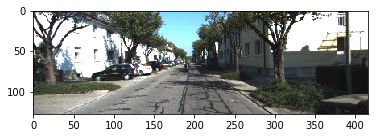

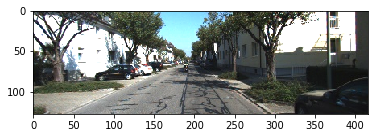

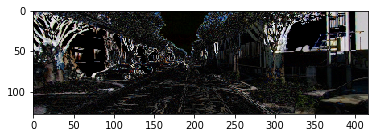

In [31]:
filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(parser)
dataset = dataset.batch(32)
iterator = dataset.make_initializable_iterator()

with tf.Session() as sess:
    # Initialize 'iterator' with training data
    training_filenames = ['/home/paperspace/DeepOdometry/train_eulcolorscale.tfrecord']
    sess.run(iterator.initializer, feed_dict={filenames: training_filenames})
    images, images_prev, labels = iterator.get_next()
    print (images, images_prev)
    images, images_prev, labels = sess.run([images, images_prev, labels])
    img = images[8].reshape((128, 416, 3))
    img_prev = images_prev[8].reshape((128, 416, 3))

    plt.imshow(img)
    plt.show()
    plt.figure()
    plt.imshow(img_prev)
    plt.show()
    plt.figure()
    plt.imshow(cv2.absdiff(img, img_prev))
    plt.show()
    
    
#     # Initialize 'iterator' with validation data
#     validation_filenames = ['train01.odometry']
#     sess.run(iterator.initializer, feed_dict={filenames: validation_filenames})
    
    

In [ ]:
[  9.99997800e-01   5.27262800e-04  -2.06693500e-03  -4.69029400e-02
  -5.29650600e-04   9.99999200e-01  -1.15486500e-03  -2.83992800e-02
   2.06632400e-03   1.15595800e-03   9.99997100e-01   8.58694100e-01]

# Build Euler TF Record

In [32]:
from transforms3d.euler import mat2euler

In [33]:
import pickle as p

with open('pose_scaler_eul.p', 'rb') as fp:
    scaler = p.load(fp)

In [34]:
csw = os.getcwd()
writer = tf.python_io.TFRecordWriter("/home/paperspace/DeepOdometry/train_eul_color_scale_tiny.tfrecord")
for sequence in train_sequences:
    print ("Sequence: ", sequence)
    dataset = odometry(basedir, sequence)
    dataset.imformat = 'cv2'
    img_raw_prev = None
    img_prev = None
    print (len(dataset.timestamps))
    for i in range(len(dataset.timestamps)):
        if i % 500 == 0:
            print (i)

        img = dataset.rgb(i)
        img = cv2.resize(img, (416, 128))
        
        img = img.astype(np.float32)
        img_raw = cv2.imencode('.jpg', img)[1].tostring()
        
        if i == 20:
            break
    
        try:
            pose = next(iter(itertools.islice(dataset.poses, i, None)))
            pose = pose[:3, :4].astype(np.float64)
            ax, ay, az = mat2euler(pose[:, 0:3])
            pose = pose[:,3].flatten().tolist()
            pose += [ax, ay, az]
            pose = np.array(pose)
            pose = scaler.transform(pose.reshape(1, -1))
            pose = pose.tostring()
        except:
            print ("No ground pose so skipping this sequence.")
            break
            
        if i == 0:
            img_raw_prev = img_raw
            img_prev = img
        else:
            example = tf.train.Example(features=tf.train.Features(feature={ # SequenceExample for seuqnce example
                "pose": _bytes_feature(pose),
                'img_raw': _bytes_feature(img_raw),
                'img_raw_prev': _bytes_feature(img_raw_prev),
            }))
            writer.write(example.SerializeToString())
            img_raw_prev = img_raw
            img_prev = img
    break
writer.close()

Sequence:  00
4541
0


In [ ]:
csw = os.getcwd()
writer = tf.python_io.TFRecordWriter("/home/paperspace/DeepOdometry/eval_eul_color_scale_tiny.tfrecord")
for sequence in test_sequences:
    print ("Sequence: ", sequence)
    dataset = odometry(basedir, sequence)
    dataset.imformat = 'cv2'
    img_raw_prev = None
    img_prev = None
    for i in range(len(dataset.timestamps)):
        if i % 500 == 0:
            print (i)

        img = dataset.rgb(i)
        img = cv2.resize(img, (416, 128))
        
        img = img.astype(np.float32)
        img_raw = cv2.imencode('.jpg', img)[1].tostring()
    
        try:
            pose = next(iter(itertools.islice(dataset.poses, i, None)))
            pose = pose[:3, :4].astype(np.float64)
            ax, ay, az = mat2euler(pose[:, 0:3])
            pose = pose[:,3].flatten().tolist()
            pose += [ax, ay, az]
            pose = np.array(pose)
            #pose = scaler.transform(pose.reshape(1, -1))
            pose = pose.tostring()
        except:
            print ("No ground pose so skipping this sequence.")
            break
            
        if i == 0:
            img_raw_prev = img_raw
            img_prev = img
        else:
            example = tf.train.Example(features=tf.train.Features(feature={ # SequenceExample for seuqnce example
                "pose": _bytes_feature(pose),
                'img_raw': _bytes_feature(img_raw),
                'img_raw_prev': _bytes_feature(img_raw_prev),
            }))
            writer.write(example.SerializeToString())
            img_raw_prev = img_raw
            img_prev = img
writer.close()